# Herbarium panoptic and instance segmentation
### With huggingface mask2former

Adapted from this notebook: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/MaskFormer/Fine-tuning/Fine_tuning_MaskFormer_on_a_panoptic_dataset.ipynb

### imports & installs

Make sure you install pytorch 2.0.X and torchvision: https://pytorch.org/get-started/locally/

#### Install huggingface and all dependencies and restart kernel

In [ ]:
%pip install -q lightning opencv-python albumentations transformers

If you encounter a bug with Pydantic, install this version

In [ ]:
#%pip install pydantic==1.10.11

### Restart runtime

In [7]:
#General libraries for various operations
import os
import sys
import time
import json
# to load in notebook
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'herbarium_segmentation')))

import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset
from transformers.image_transforms import rgb_to_id, id_to_rgb

from mask2former_models import Mask2FormerModel
from mask2former_models import get_transforms, get_processor, download_model, draw_panoptic_segmentation


### Inference with pretrained models

#### Load/download model
Choose from: **[panoptic,instance]** for model name.

In [ ]:
data_dir = '../datasets/plantclef'
categories_path = os.path.join(data_dir, 'panoptic_herbaria_categories.json')

with open(categories_path, 'r') as f:
    categories = json.load(f)

reduce_labels=True

# USING REDUCE LABELS so add -1
if reduce_labels:
    id2label = {int(c['id'])-1:c['name'] for c in categories}
else:
    # without reduce labels
    id2label = {int(c['id']):c['name'] for c in categories}
print('id2label:', id2label)

# panoptic, or instance
model_name = 'panoptic' 

if model_name == 'panoptic':
    model_path = '../herbarium_segmentation/models/m2f_panoptic.ckpt'
else:
    model_path = '../herbarium_segmentation/models/m2f_instance.ckpt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch device:',device)

# download or load model
model = download_model(model_path=model_path, id2label=id2label, model_name=model_name)
model.eval()

#### Inference on Single image

Image shape: (1024, 692, 3)
Model inputs:
pixel_values torch.Size([1, 3, 800, 600])
pixel_mask torch.Size([1, 800, 600])


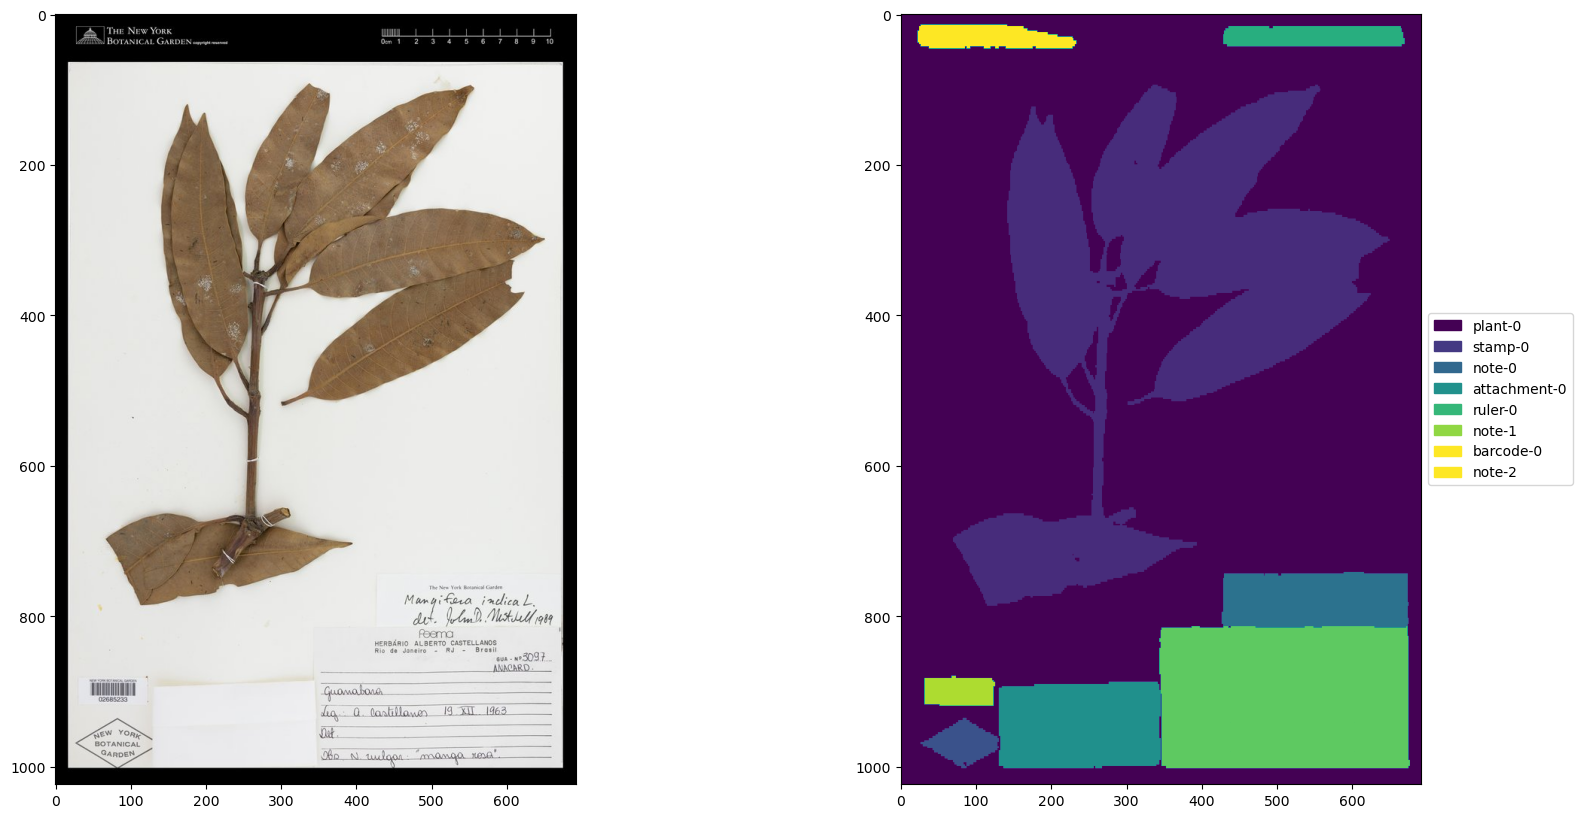

In [19]:
# Load image and convert to RGB
img_path = '../datasets/sample/img/10737.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape:', img.shape)
# get transform
_, validation_transform = get_transforms()
processor = get_processor(model_name=model_name, reduce_labels=reduce_labels)
input_img = validation_transform(image=img)['image']
inputs = processor(images=input_img, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
print('Model inputs:')

for k,v in inputs.items():
  print(k,v.shape)

with torch.no_grad():
    outputs = model(**inputs)

# postprocess panoptic gives much worse results.
results = processor.post_process_instance_segmentation(outputs, target_sizes=[img.shape[:2]])[0]
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
draw_panoptic_segmentation(results['segmentation'].cpu(), results['segments_info'], id2label=id2label)
plt.show()

#### Inference on image folder and Retrain is TODO